<a href="https://colab.research.google.com/github/akizeng/APM-Project/blob/master/CNN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle

!mkdir -p ~/.kaggle
!echo '{"username":"vkhanijow","key":"f31dffe2714de1de287ceee28dc363f9"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c humpback-whale-identification

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 67.8MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 80.2MB/s]
100% 1.35G/1.35G [00:14<00:00, 109MB/s]

100% 4.15G/4.16G [00:32<00:00, 173MB/s]
100% 4.16G/4.16G [00:32<00:00, 139MB/s]


In [0]:
!unzip \*.zip

In [0]:
%matplotlib inline
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('train.zip', 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall('train')

In [0]:
df = pd.read_csv('train.csv')

In [0]:
df.head()
len(df)

25361

Text(0, 0.5, 'Numbers')

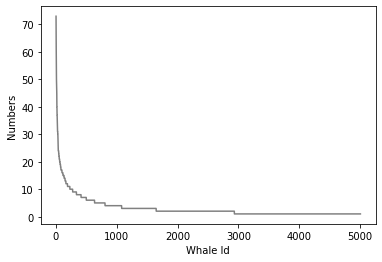

In [0]:
df2 = df.groupby('Id').count().sort_values(by='Image',ascending=False).reset_index()
plt.plot(df2['Image'][1:],c='grey')
plt.xlabel('Whale Id')
plt.ylabel('Numbers')

In [0]:
len(df2[df2['Image']<10])/len(df2)

0.9452547452547453

In [0]:
df2['Image'][0]/df2['Image'].sum()

0.3810575292772367

In [0]:
TRAIN ="train"
TEST = "test"
LABELS = "train.csv"
SUB = "sample_submission.csv"

IMG_SIZE = 200


def text2number(LABELS):
    df = pd.read_csv(LABELS)
    
    uni_labels = pd.DataFrame(df['Id'].unique(),columns=['Id'])
    uni_labels.index.name = 'ID_new'
    uni_labels = uni_labels.reset_index()


    df = df.merge(uni_labels,on='Id')
    
    return df
    
#submit = [p for _, p, _ in pd.read_csv(SUB).to_records()]
#join = list(tagged.keys()) + submit
df = text2number(LABELS)

tagged = dict([(p, w) for _, p,_, w in df.to_records()])

9c2ad64a9.jpg


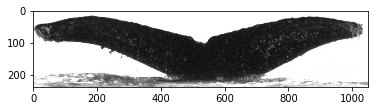

In [0]:
path = os.path.abspath(TRAIN)
for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    print(img)
    plt.imshow(img_array,cmap='gray')
    plt.show()
    break

In [0]:
print(img_array.shape)

(239, 1050)


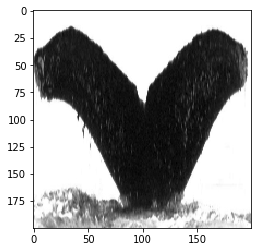

In [0]:
IMG_SIZE = 200

new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
plt.imshow(new_array,cmap='gray')
plt.show()

In [0]:
pd.read_csv(LABELS).to_records()

rec.array([(    0, '0000e88ab.jpg', 'w_f48451c'),
           (    1, '0001f9222.jpg', 'w_c3d896a'),
           (    2, '00029d126.jpg', 'w_20df2c5'), ...,
           (25358, 'fff9002e0.jpg', 'w_bd1c3d5'),
           (25359, 'fffcde6fe.jpg', 'w_9f30885'),
           (25360, 'fffde072b.jpg', 'new_whale')],
          dtype=[('index', '<i8'), ('Image', 'O'), ('Id', 'O')])

In [0]:
df.head()

,Image,Id,ID_new
0,0000e88ab.jpg,w_f48451c,0
1,0af805558.jpg,w_f48451c,0
2,1c351b88e.jpg,w_f48451c,0
3,6f7abb1be.jpg,w_f48451c,0
4,77a44bf94.jpg,w_f48451c,0


In [0]:
df.to_csv('index_tag.csv')

In [0]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [0]:
def create_training_data():
    count = 1
    training_data = []
    class_num = []
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
        class_num = tagged[img]
        training_data.append([new_array,class_num])
        count += 1
      except Exception as e:
          pass           
      else:
          pass
      
      return training_data
    
train_data = create_training_data()

In [0]:
train_data[:5]

[[array([[254, 254, 254, ..., 254, 254, 254],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [248, 246, 246, ..., 254, 252, 253],
         [248, 246, 244, ..., 253, 253, 254],
         [245, 245, 243, ..., 252, 252, 250]], dtype=uint8), 572]]

In [0]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img(dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train 

In [0]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [0]:

X = prepareImages(df, df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  0baa89964.jpg
Processing image:  1001 ,  1984f2d9f.jpg
Processing image:  1501 ,  26e271ca5.jpg
Processing image:  2001 ,  34481f22e.jpg
Processing image:  2501 ,  4110e4a11.jpg
Processing image:  3001 ,  4dd7de9b0.jpg
Processing image:  3501 ,  5a98812a7.jpg
Processing image:  4001 ,  68a4ff4e2.jpg
Processing image:  4501 ,  75f1368d1.jpg
Processing image:  5001 ,  828a0641d.jpg
Processing image:  5501 ,  8fdecbd92.jpg
Processing image:  6001 ,  9c9fd59ef.jpg
Processing image:  6501 ,  a93955ecc.jpg
Processing image:  7001 ,  b665f5243.jpg
Processing image:  7501 ,  c4ecb125f.jpg
Processing image:  8001 ,  d2b5789f2.jpg
Processing image:  8501 ,  df15cc35a.jpg
Processing image:  9001 ,  ed38599c2.jpg
Processing image:  9501 ,  fa9699838.jpg
Processing image:  10001 ,  5eb83a49f.jpg
Processing image:  10501 ,  e9ac41eae.jpg
Processing image:  11001 ,  60fd46031.jpg
Processing image:  11501 ,  b17668b8c.jpg

In [0]:
y, label_encoder = prepare_labels(df['Id'])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
y.shape

(25361, 5005)

In [0]:
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(512, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)       

In [0]:
history = model.fit(X, y, epochs=100, batch_size=100, verbose=1)
#gc.collect()

Epoch 1/100
25361/25361 [==============================] - 11s 442us/step - loss: 6.1817 - acc: 0.3795
Epoch 2/100
25361/25361 [==============================] - 11s 414us/step - loss: 5.9085 - acc: 0.3811
Epoch 3/100
25361/25361 [==============================] - 11s 416us/step - loss: 5.7923 - acc: 0.3811
Epoch 4/100
25361/25361 [==============================] - 11s 415us/step - loss: 5.7489 - acc: 0.3811
Epoch 5/100
25361/25361 [==============================] - 11s 417us/step - loss: 5.7067 - acc: 0.3811
Epoch 6/100
25361/25361 [==============================] - 11s 416us/step - loss: 5.6760 - acc: 0.3811
Epoch 7/100
25361/25361 [==============================] - 11s 415us/step - loss: 5.6463 - acc: 0.3811
Epoch 8/100
25361/25361 [==============================] - 10s 413us/step - loss: 5.6247 - acc: 0.3811
Epoch 9/100
25361/25361 [==============================] - 11s 416us/step - loss: 5.5834 - acc: 0.3811
Epoch 10/100
25361/25361 [==============================] - 11s 415us/ste

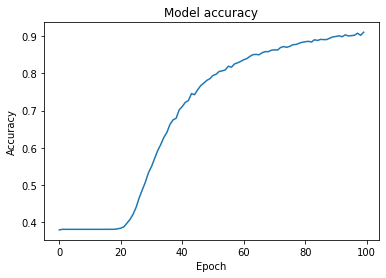

In [0]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()